In [53]:
from mqdq import utils, babble, elegy, ngrams
from mqdq import line_analyzer as la
from mqdq import mahalanobis as maha

import bs4
import glob

import numpy as np
import pandas as pd
import scipy as sp

from scipy.stats import uniform, randint

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, cross_validate, RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

from xgboost import XGBClassifier

In [81]:
import warnings
warnings.filterwarnings(action='once')

In [80]:
%load_ext rpy2.ipython

/Users/ben/silius/silius_env/lib/python3.7/site-packages/jinja2/utils.py:485: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping
/Users/ben/silius/silius_env/lib/python3.7/site-packages/jinja2/runtime.py:318: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/Users/ben/silius/silius_env/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [4]:
collection = []

# Several lines need to be manually deleted, because when we make wide vectors
# we treat couplets as a unit (so we must have a matching number of H and P.)
# In some poems, we have corrupt lines, and so we delete the H that matches
# a corrupt P and vice versa.

ep = babble.bookbabs('ovid/OV-epis.xml', name="Ep.")
for b in ep:
    b.author = 'Ovid'
collection.extend(ep)

tr = babble.multi_bookbabs(sorted(glob.glob('ovid/OV-tri*.xml')), name="Tr.")
for b in tr:
    b.author = 'Ovid'
collection.extend(tr)

am = babble.multi_bookbabs(sorted(glob.glob('ovid/OV-amo*.xml')), name="Am.")
for b in am:
    b.author = 'Ovid'
collection.extend(am)

tib = babble.multi_bookbabs(sorted(glob.glob('TIB-ele*.xml')), name="Tib.")
del tib[1].raw_source[24]
for b in tib:
    b.author = 'Tibullus'
collection.extend(tib)

prop = babble.multi_bookbabs(sorted(glob.glob('PROP-ele*.xml')), name="Prop.")
for b in prop:
    b.author = 'Propertius'
del prop[55].raw_source[28]
collection.extend(prop)

cat = babble.bookbabs('CATVLL-carm.xml', name="Cat.")
cat_ele = [x for x in cat if x.elegiac and len(x) > 20]
for b in cat_ele:
    b.author = 'Catullus'
del cat_ele[3].raw_source[46]
collection.extend(cat_ele)

pon = babble.multi_bookbabs(sorted(glob.glob('ovid/OV-pon*.xml')), name="Pont.")
for b in pon:
    b.author = 'Ovid'
del pon[1].raw_source[8]
del pon[7].raw_source[18]
collection.extend(pon)


In [5]:
def vectorise_babs(babs):
    vecs = []
    for b in babs:
        v=pd.DataFrame()
        v['Chunk'] = [''.join(ngrams._just_stringify(b.raw_source, type='phon'))]
        v.insert(0, 'Poem', b.name)
        v.insert(0, 'Work', b.name.split(' ')[0])
        if hasattr(b,'author'):
            v.insert(0, 'Author', b.author)
        vecs.append(v)
    df = pd.concat(vecs)
    df.reset_index(drop=True,inplace=True)
    return df

In [9]:
vecs = vectorise_babs(collection)
vecs

,Author,Work,Poem,Chunk
0,Ovid,Ep.,Ep. 1,hank tua penelope lento tibi mittit ulikse\nni...
1,Ovid,Ep.,Ep. 2,hospita demopoon tua te rodopeia pyllis\nultra...
2,Ovid,Ep.,Ep. 3,kwam legis a rapta briseide littera wenit\nwik...
3,Ovid,Ep.,Ep. 4,kwam nisi tu dederis karitura_st ipsa salutem\...
4,Ovid,Ep.,Ep. 5,perlegis an konjunks prohibet nowa perlege non...
...,...,...,...,...
273,Ovid,Pont.,Pont. 4 12,kwo minus in nostris ponaris amike libellis\nn...
274,Ovid,Pont.,Pont. 4 13,o mihi non dubios inter memorande sodales\nkwi...
275,Ovid,Pont.,Pont. 4 14,haek tibi mittuntur kwem sum modo karmine kwes...
276,Ovid,Pont.,Pont. 4 15,sikwis adhuk uskwam nostri non immemor ekstat\...


In [19]:
vecs.insert(3, 'LEN', [len(b) for b in collection])
vecs


,Author,Work,Poem,LEN,Chunk
0,Ovid,Ep.,Ep. 1,116,hank tua penelope lento tibi mittit ulikse\nni...
1,Ovid,Ep.,Ep. 2,148,hospita demopoon tua te rodopeia pyllis\nultra...
2,Ovid,Ep.,Ep. 3,154,kwam legis a rapta briseide littera wenit\nwik...
3,Ovid,Ep.,Ep. 4,176,kwam nisi tu dederis karitura_st ipsa salutem\...
4,Ovid,Ep.,Ep. 5,158,perlegis an konjunks prohibet nowa perlege non...
...,...,...,...,...,...
273,Ovid,Pont.,Pont. 4 12,50,kwo minus in nostris ponaris amike libellis\nn...
274,Ovid,Pont.,Pont. 4 13,50,o mihi non dubios inter memorande sodales\nkwi...
275,Ovid,Pont.,Pont. 4 14,62,haek tibi mittuntur kwem sum modo karmine kwes...
276,Ovid,Pont.,Pont. 4 15,42,sikwis adhuk uskwam nostri non immemor ekstat\...


In [127]:
DIMS = 50

pa = lambda: make_pipeline(
    TfidfVectorizer(sublinear_tf=True, use_idf=True, norm='l2', analyzer='char', ngram_range=(2,4)),
    TruncatedSVD(DIMS),
    Normalizer(copy=False),
    PassiveAggressiveClassifier(max_iter=1000, tol=1e-3, C=1.0, loss='squared_hinge')
)
etn = lambda: make_pipeline(
    StandardScaler(),
    ExtraTreesClassifier(n_estimators=5000, max_features=15, criterion='gini', n_jobs=-1)
)
svmn = lambda: make_pipeline(
    TfidfVectorizer(sublinear_tf=True, use_idf=True, norm='l2', analyzer='char', ngram_range=(2,4)),
    TruncatedSVD(DIMS),
    Normalizer(copy=False),
    SVC(gamma='scale', kernel='rbf', C=128)
)
svm = lambda: make_pipeline(
    TfidfVectorizer(sublinear_tf=True, use_idf=True, norm='l2', analyzer='char', ngram_range=(2,4)),
    SVC(gamma='scale', kernel='rbf', C=128)
)
svml = lambda: make_pipeline(
    TfidfVectorizer(sublinear_tf=True, use_idf=True, norm='l2', analyzer='char', ngram_range=(2,4)),
    TruncatedSVD(DIMS),
    Normalizer(copy=False),
    LinearSVC()
)
mnb =  lambda: make_pipeline(
    TfidfVectorizer(sublinear_tf=True, use_idf=True, norm='l2', analyzer='char', ngram_range=(2,4)),
    TruncatedSVD(DIMS),
    MultinomialNB()
)

nc =  lambda: make_pipeline(
    TfidfVectorizer(sublinear_tf=True, use_idf=True, norm='l2', analyzer='char', ngram_range=(2,4)),
    TruncatedSVD(DIMS),
    Normalizer(copy=False),
    NearestCentroid()
)
ncfull =  lambda: make_pipeline(
    TfidfVectorizer(sublinear_tf=True, use_idf=True, norm='l2', analyzer='char', ngram_range=(2,4)),
    NearestCentroid()
)
xgb = lambda: make_pipeline(
    TfidfVectorizer(sublinear_tf=True, use_idf=True, norm='l2', analyzer='char', ngram_range=(2,4)),
    TruncatedSVD(64),
    Normalizer(copy=False),
    # magic numbers! Found by RandomSearchCV. XGBoost was performing badly (it still is)
    # and I wanted to give it the best possible chance to defend its reputation.
    XGBClassifier(
        objective="multi:softmax",
        colsample_bytree=0.8,
        gamma=0.06,
        learning_rate=0.17,
        max_depth=5,
        n_estimators=110,
        subsample=0.84)
)

CLASSIFIERS = [
    ('PassiveAggressive', pa),
    #('ExtraTreesNorm', etn),
    ('XGBoost',xgb),
    #('Linear SVC Scaled', lin_svmn),
    # ('SVM', svmn),
    ('SVM (Linear)', svml),
    #('SVM', svm),
    #('MultinomialNB', mnb),
    ('NearestCentroid LSA', nc),
    ('NearestCentroid', ncfull)

]

In [33]:
def test_clfs(clfs, corp, by, cutoff=0, seed=None, samps=20):
    """
    Test the given classifiers on a corpus.
    
    Multi-label fitting strategy is up to each classifier.
    """
    res = []
    # this makes a seeded rng, instead of seeding the ShuffleSplit
    # with the same value each time, which seems slightly cleaner.
    rng = np.random.RandomState(seed=seed)
    for (name, c) in clfs:
        trimmed = corp[corp.LEN >= cutoff]
        X,y = trimmed.Chunk, trimmed[by]
        cv = StratifiedShuffleSplit(n_splits=samps, test_size=0.2, random_state=rng)
        # note to self: don't run parallel jobs if you have a seeded rng >:(
        jobs = -1
        if seed:
            jobs = 1
        samp_res = cross_val_score(c(), X, y, cv=cv, n_jobs=jobs, scoring='f1_weighted')
        m = sp.mean(samp_res)
        ci = sp.stats.t.interval(
            alpha=0.95,
            df=len(samp_res)-1,
            loc=m,
            scale=sp.stats.sem(samp_res)
        ) 
        res.append({'Classifier':name, 'Score':m, 'Cutoff': cutoff, 'CILow':ci[0], 'CIHigh':ci[1]})
    return pd.DataFrame(res)

In [128]:
test_clfs(CLASSIFIERS, vecs, 'Work')

,Classifier,Score,Cutoff,CILow,CIHigh
0,PassiveAggressive,0.743447,0,0.711034,0.775861
1,XGBoost,0.710269,0,0.685934,0.734604
2,SVM (Linear),0.832646,0,0.816314,0.848978
3,NearestCentroid LSA,0.728842,0,0.707990,0.749695
4,NearestCentroid,0.831178,0,0.810114,0.852243


In [108]:
test_clfs(CLASSIFIERS, vecs, 'Author')

,Classifier,Score,Cutoff,CILow,CIHigh
0,PassiveAggressive,0.917095,0,0.901720,0.932470
1,XGBoost,0.833301,0,0.815908,0.850693
2,SVM,0.928248,0,0.914334,0.942162
3,SVM (Linear),0.905022,0,0.888312,0.921732
4,NearestCentroid,0.860010,0,0.843997,0.876023


In [68]:
X = vecs.Chunk
y = vecs.Work

steps = [
    ('vec', TfidfVectorizer(sublinear_tf=True, use_idf=True, norm='l2', analyzer='char', ngram_range=(2,4))),
    ('SVD', TruncatedSVD(50)),
    ('norm', Normalizer(copy=False)),
    ('xgb', XGBClassifier(objective="multi:softmax",eval_metric='mlogloss'))
]
pipeline = Pipeline(steps)

params = {
    "xgb__colsample_bytree": uniform(0.7, 0.3),
    "xgb__gamma": uniform(0, 0.5),
    "xgb__learning_rate": uniform(0.03, 0.3), # default 0.1 
    "xgb__max_depth": randint(2, 6), # default 3
    "xgb__n_estimators": randint(100, 150), # default 100
    "xgb__subsample": uniform(0.6, 0.4),
    "SVD__n_components": randint(20,80),
}

search = RandomizedSearchCV(pipeline, param_distributions=params, n_iter=200, cv=3, verbose=1, n_jobs=-1, return_train_score=True)

search.fit(X, y)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 34.1min finished
/Users/ben/silius/silius_env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/ben/silius/silius_env/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integ

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('vec',
                                              TfidfVectorizer(analyzer='char',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                         

In [63]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [69]:
report_best_scores(search.cv_results_, 1)

Model with rank: 1
Mean validation score: 0.691 (std: 0.088)
Parameters: {'SVD__n_components': 71, 'xgb__colsample_bytree': 0.738069456310769, 'xgb__gamma': 0.10434450640239068, 'xgb__learning_rate': 0.32221100620008636, 'xgb__max_depth': 5, 'xgb__n_estimators': 137, 'xgb__subsample': 0.970285172946948}

Model with rank: 1
Mean validation score: 0.691 (std: 0.125)
Parameters: {'SVD__n_components': 67, 'xgb__colsample_bytree': 0.8374038565295792, 'xgb__gamma': 0.029678435378607815, 'xgb__learning_rate': 0.18369287202337697, 'xgb__max_depth': 4, 'xgb__n_estimators': 129, 'xgb__subsample': 0.7217079712076697}



In [77]:
dfs = []
for n in range(0,80,5):
    dfs.append(test_clfs(CLASSIFIERS, vecs, 'Work', cutoff=n, samps=100))
bywork = pd.concat(dfs)
bywork

,Classifier,Score,Cutoff,CILow,CIHigh
0,PassiveAggressive,0.759040,0,0.745955,0.772125
1,XGBoost,0.711059,0,0.699751,0.722368
2,SVM,0.740097,0,0.728429,0.751765
3,NearestCentroid,0.819499,0,0.811031,0.827967
0,PassiveAggressive,0.767986,5,0.756025,0.779948
...,...,...,...,...,...
3,NearestCentroid,0.738650,70,0.722171,0.755129
0,PassiveAggressive,0.658147,75,0.635385,0.680909
1,XGBoost,0.606366,75,0.584014,0.628718
2,SVM,0.430826,75,0.409291,0.452361


In [78]:
dicts = []
for n in range(0,80,10):
    dicts.append({'Cutoff':n, 'N':len(vecs[vecs.LEN >= n])})
n_df = pd.DataFrame(dicts)
n_df

,Cutoff,N
0,0,278
1,10,277
2,20,270
3,30,236
4,40,194
5,50,156
6,60,113
7,70,90


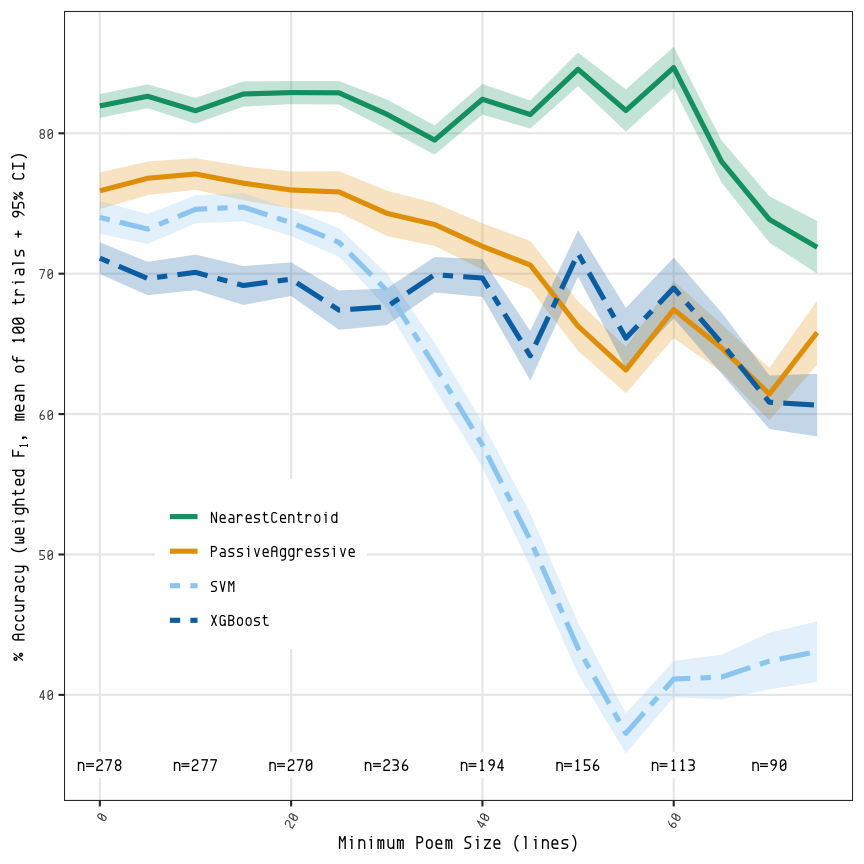

In [103]:
%%R -i bywork,n_df -h 6 -w 6 -u in -r 144
library(ggplot2)
library(extrafont)
cbbPaletteDark <- c("#009E73", "#e79f00", "#9ad0f3", "#0072B2", "#D55E00", 
    "#CC79A7", "#F0E442")
greys <- c(grey(0),grey(0.35), grey(0.45), grey(0.75))

ggplot(data=bywork, aes(x=Cutoff, y=Score*100)) +
#This CI band is not shown in the B&W figure, because it's not useful in monochrome
geom_label(
    data=n_df,
    label.size=NA,
    aes(x=Cutoff, y=35, label=sprintf("n=%d",N)),
    family="Envy Code R",
    size=3
) +
geom_ribbon(
    aes(ymin=CILow*100, ymax=CIHigh*100, fill=Classifier), 
    alpha=0.25, show.legend=FALSE) +
geom_line(aes(color=Classifier,linetype=Classifier), size=1.2) +

labs(x="Minimum Poem Size (lines)",y=expression(paste("% Accuracy (weighted ",F[1],", mean of 100 trials + 95% CI)"))) +
theme_bw() +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank(), legend.title=element_blank()) +
guides(color = guide_legend(ncol=2)) +
theme(legend.title=element_blank(), legend.position= c(0.25, 0.3), legend.text=element_text(size=8)) +
#theme(legend.position="bottom") +
theme(axis.text.x = element_text(angle = 60, hjust = 1, vjust=1)) +
scale_linetype_manual(values=c("solid", "solid", "twodash", "twodash")) +
# scale_x_continuous(breaks = seq(0,22,2)) +
# scale_y_continuous(breaks = seq(85,100,2.5)) +
# scale_color_manual(values=greys)
scale_color_manual(values=cbbPaletteDark) +
scale_fill_manual(values=cbbPaletteDark)

# fn <- "/Users/ben/silius/ep15/ngram_acc_work.pdf"
# ggsave(fn, dpi=600, width=6, height=6)
# embed_fonts(fn)

In [87]:
dfs = []
for n in range(0,80,5):
    dfs.append(test_clfs(CLASSIFIERS, vecs, 'Author', cutoff=n, samps=100))
byauth = pd.concat(dfs)
byauth

,Classifier,Score,Cutoff,CILow,CIHigh
0,PassiveAggressive,0.926899,0,0.920856,0.932941
1,XGBoost,0.830432,0,0.822642,0.838221
2,SVM,0.918498,0,0.911736,0.925261
3,NearestCentroid,0.878318,0,0.870900,0.885736
0,PassiveAggressive,0.922077,5,0.916386,0.927768
...,...,...,...,...,...
3,NearestCentroid,0.764412,70,0.748723,0.780102
0,PassiveAggressive,0.729973,75,0.717586,0.742360
1,XGBoost,0.810951,75,0.796268,0.825633
2,SVM,0.761099,75,0.750775,0.771422


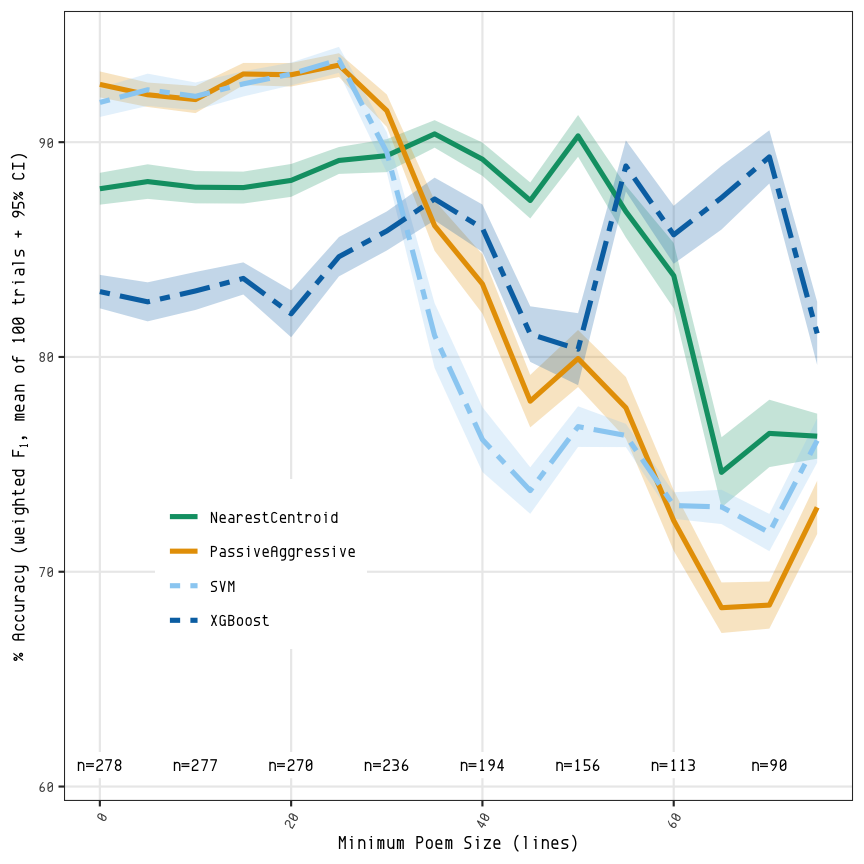

In [102]:
%%R -i byauth,n_df -h 6 -w 6 -u in -r 144
library(ggplot2)
cbbPaletteDark <- c("#009E73", "#e79f00", "#9ad0f3", "#0072B2", "#D55E00", 
    "#CC79A7", "#F0E442")
greys <- c(grey(0),grey(0.35), grey(0.45), grey(0.75))

ggplot(data=byauth, aes(x=Cutoff, y=Score*100)) +
#This CI band is not shown in the B&W figure, because it's not useful in monochrome
geom_label(
    data=n_df,
    label.size=NA,
    aes(x=Cutoff, y=61, label=sprintf("n=%d",N)),
    family="Envy Code R",
    size=3
) +
geom_ribbon(
    aes(ymin=CILow*100, ymax=CIHigh*100, fill=Classifier), 
    alpha=0.25, show.legend=FALSE) +
geom_line(aes(color=Classifier,linetype=Classifier), size=1.2) +

labs(x="Minimum Poem Size (lines)",y=expression(paste("% Accuracy (weighted ",F[1],", mean of 100 trials + 95% CI)"))) +
theme_bw() +
theme(text = element_text(size=9, family="Envy Code R"), panel.grid.minor=element_blank(), legend.title=element_blank()) +
guides(color = guide_legend(ncol=2)) +
theme(legend.title=element_blank(), legend.position= c(0.25, 0.3), legend.text=element_text(size=8)) +
#theme(legend.position="bottom") +
theme(axis.text.x = element_text(angle = 60, hjust = 1, vjust=1)) +
scale_linetype_manual(values=c("solid", "solid", "twodash", "twodash")) +
# scale_x_continuous(breaks = seq(0,22,2)) +
# scale_y_continuous(breaks = seq(85,100,2.5)) +
# scale_color_manual(values=greys)
scale_color_manual(values=cbbPaletteDark) +
scale_fill_manual(values=cbbPaletteDark)

# fn <- "/Users/ben/silius/ep15/ngram_acc_auth.pdf"
# ggsave(fn, dpi=600, width=6, height=6)
# embed_fonts(fn)

In [122]:
conf_matrix_list_of_arrays = []
X = vecs.Chunk
y = vecs.Work
names = sorted(y.unique())
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
clf = make_pipeline(
    TfidfVectorizer(sublinear_tf=True, use_idf=True, norm='l2', analyzer='char', ngram_range=(2,4)),
    TruncatedSVD(50, random_state=42),
    Normalizer(),
    NearestCentroid(),
)

for train_index, test_index in sss.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    conf_matrix = confusion_matrix(y_test, clf.predict(X_test))
    conf_matrix_list_of_arrays.append(conf_matrix)

In [123]:
conf_mat = np.mean(conf_matrix_list_of_arrays, axis=0)

In [124]:
# build the df for ggplot
cm_pct = [x/x.sum()*100 for x in conf_mat]
m = []
names = sorted(vecs['Work'].unique())
for y,arr in enumerate(cm_pct):
    for x,val in enumerate(arr):
        m.append({'x':names[x], 'y':names[y], 'val':val})
cmdf = pd.DataFrame(m)
cmdf.head()

,x,y,val
0,Am.,Am.,83.1
1,Cat.,Am.,0.0
2,Ep.,Am.,5.9
3,Pont.,Am.,4.8
4,Prop.,Am.,1.4


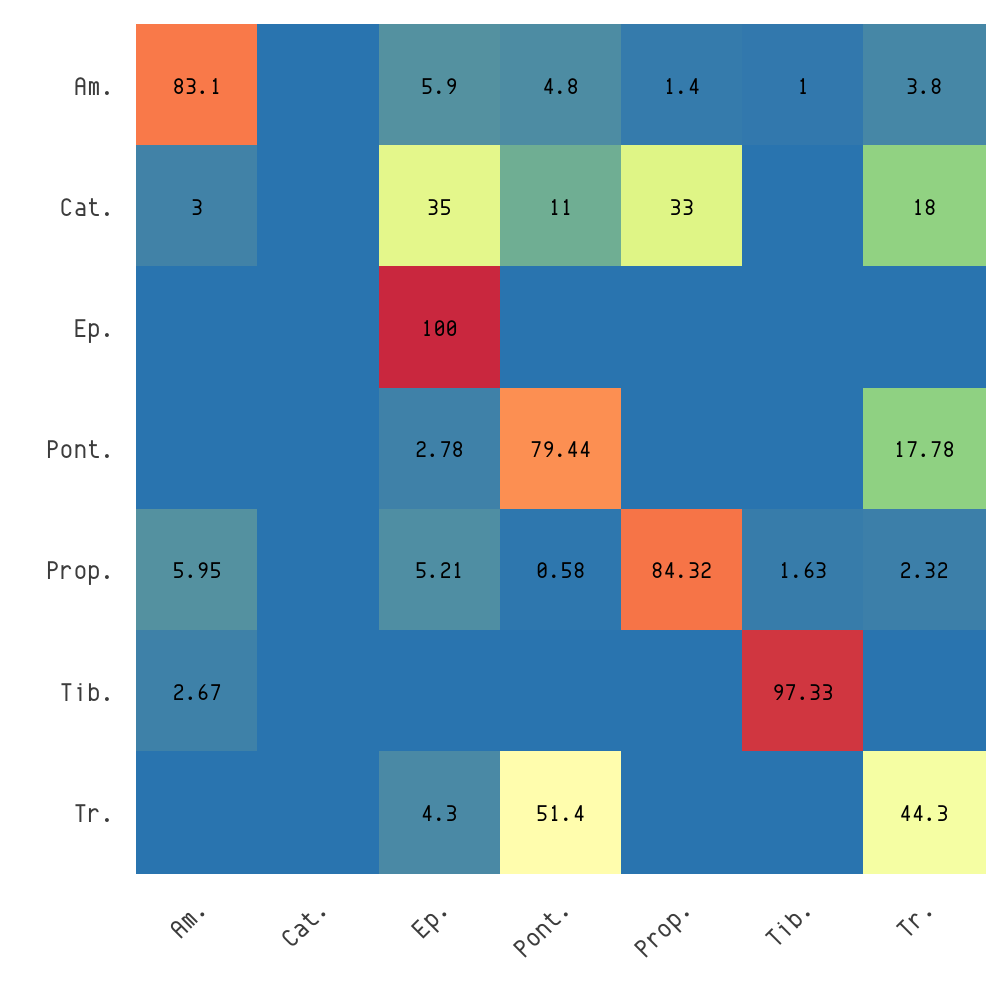

In [126]:
%%R -i cmdf -h 7 -w 7 -u in -r 144

source('/Users/ben/r/theme_black.R')

library(tidyverse)
library(extrafont)
cmdf <- cmdf %>%
  mutate(x = factor(x, levels= unique(x)), # alphabetical order by default
         y = factor(y, levels = rev(unique(y)))) # force reverse alphabetical order
    
ggplot(cmdf, aes(x=x, y=y, fill=val)) +
# slightly overlap the tiles to avoid a visible border line
geom_tile(width=1.01, height=1.01) +
scale_fill_distiller(palette="Spectral", direction=-1) +
guides(fill=F) + # removing legend for `fill`
theme_minimal() +
# force it to be square
coord_equal() +
# supress output for 0
geom_text(
    aes(label=ifelse(round(cmdf$val,digits=2)==0, "", round(val,digits=2))),
    color="black",
    size=4,
    family="Envy Code R") + 
theme(
    text = element_text(size=16, family="Envy Code R"),
    panel.grid.minor=element_blank(),
    panel.grid.major=element_blank(),
    panel.border=element_blank(),
    legend.title=element_blank()
) +
theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust=0.95)) +
labs(x="", y="") +
theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5))

# fn <- "ep15/cm_ngrams.pdf"
# ggsave(fn, dpi=600, height=7, width=7)